# Sales order data exploration
Use this notebook to explore sales order data


In [39]:
from pyspark.sql.types import *

orderSchema = StructType([
    StructField("SalesOrderNumber", StringType()),
    StructField("SalesOrderLineNumber", IntegerType()),
    StructField("OrderDate", DateType()),
    StructField("CustomerName", StringType()),
    StructField("Email", StringType()),
    StructField("Item", StringType()),
    StructField("Quantity", IntegerType()),
    StructField("UnitPrice", FloatType()),
    StructField("Tax", FloatType())
])

df = spark.read.format("csv").schema(orderSchema).load("Files/orders/*.csv")

display(df)

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 41, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 124493cb-289e-40e8-b01b-784ae23082c1)

In [40]:
customers = df.select("CustomerName", "Email")

print(customers.count())
print(customers.distinct().count())

display(customers.distinct())

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 42, Finished, Available, Finished)

32718
12427


SynapseWidget(Synapse.DataFrame, 3398a769-8d63-4d8f-b99b-bc5c6d387faa)

In [41]:
productSales = df.select("Item", "Quantity").groupBy("Item").sum()

display(productSales)

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 43, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, bf875d64-fa29-4a19-aec6-af48690d099d)

In [42]:
from pyspark.sql.functions import *

yearlySales = df.select(year(col("OrderDate")).alias("FYear")).groupBy("FYear").count().orderBy("FYear")

display(yearlySales)

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 44, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, f410fb8d-8bfd-478e-b358-7b62fe8b145a)

In [43]:
from pyspark.sql.functions import *

# Create Year and Month columns
transformed_df = df.withColumn("Year", year(col("OrderDate"))).withColumn("Month", month(col("OrderDate")))

# Create the new FirstName and LastName fields
transformed_df = transformed_df.withColumn("FirstName", split(col("CustomerName"), " ").getItem(0)).withColumn("LastName", split(col("CustomerName"), " ").getItem(1))

# Filter and reorder columns
transformed_df = transformed_df["SalesOrderNumber", "SalesOrderLineNumber", "OrderDate", "Year", "Month", "FirstName", "LastName", "Email", "Item", "Quantity", "UnitPrice", "Tax"]

# Display the first five orders
display(transformed_df.limit(5))

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 45, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 0f3406bc-58f4-409a-a3f3-8fd824a59a13)

In [44]:
transformed_df.write.mode("overwrite").parquet('Files/transformed_data/orders')

print ("Transformed data saved!")

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 46, Finished, Available, Finished)

Transformed data saved!


In [45]:
orders_df = spark.read.format("parquet").load("Files/transformed_data/orders")
display(orders_df)

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 47, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 6b241877-e1e1-4522-9943-d0189ccbc6b8)

In [46]:
orders_df.write.partitionBy("Year","Month").mode("overwrite").parquet("Files/partitioned_data")

print ("Transformed data saved!")

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 48, Finished, Available, Finished)

Transformed data saved!


In [47]:
orders_2021_df = spark.read.format("parquet").load("Files/partitioned_data/Year=2021/Month=*")

display(orders_2021_df)

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 49, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ee7f963f-b187-40f8-b638-60bf8963ff97)

In [48]:
# Create a new table
df.write.format("delta").saveAsTable("salesorders")

# Get the table description
spark.sql("DESCRIBE EXTENDED salesorders").show(truncate=False)

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 50, Finished, Available, Finished)

+----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------+-------+
|col_name                    |data_type                                                                                                                                |comment|
+----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------+-------+
|SalesOrderNumber            |string                                                                                                                                   |NULL   |
|SalesOrderLineNumber        |int                                                                                                                                      |NULL   |
|OrderDate                   |date                                                                                 

In [49]:
df = spark.sql("SELECT * FROM LakeHouse.dbo.salesorders LIMIT 1000")
display(df)

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 51, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, f5c032a4-c160-442b-9f2b-7a4147a49f88)

In [50]:
%%sql
SELECT YEAR(OrderDate) AS OrderYear,
       SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue
FROM salesorders
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 52, Finished, Available, Finished)

<Spark SQL result set with 3 rows and 2 fields>

In [51]:
%%sql
SELECT * FROM salesorders

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 53, Finished, Available, Finished)

<Spark SQL result set with 1000 rows and 9 fields>

In [52]:
sqlQuery = "SELECT CAST(YEAR(OrderDate) AS CHAR(4)) AS OrderYear, \
                SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue, \
                COUNT(DISTINCT SalesOrderNumber) AS YearlyCounts \
            FROM salesorders \
            GROUP BY CAST(YEAR(OrderDate) AS CHAR(4)) \
            ORDER BY OrderYear"
df_spark = spark.sql(sqlQuery)
df_spark.show()

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 54, Finished, Available, Finished)

+---------+--------------------+------------+
|OrderYear|        GrossRevenue|YearlyCounts|
+---------+--------------------+------------+
|     2019|   4172169.969970703|        1201|
|     2020|   6882259.268127441|        2733|
|     2021|1.1547835291696548E7|       12525|
+---------+--------------------+------------+



StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 58, Finished, Available, Finished)

<Figure size 640x480 with 0 Axes>

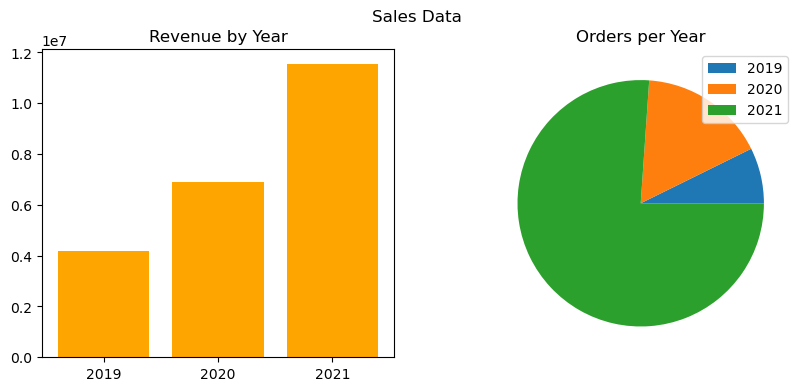

In [56]:
from matplotlib import pyplot as plt

# Clear the plot area
plt.clf()

# Create a figure for 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize = (10,4))

# Create a bar plot of revenue by year on the first axis
ax[0].bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')
ax[0].set_title('Revenue by Year')

# Create a pie chart of yearly order counts on the second axis
ax[1].pie(df_sales['YearlyCounts'])
ax[1].set_title('Orders per Year')
ax[1].legend(df_sales['OrderYear'])

# Add a title to the Figure
fig.suptitle('Sales Data')

# Show the figure
plt.show()

StatementMeta(, 18ad4bae-94da-4875-97fe-df729ede37ca, 61, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


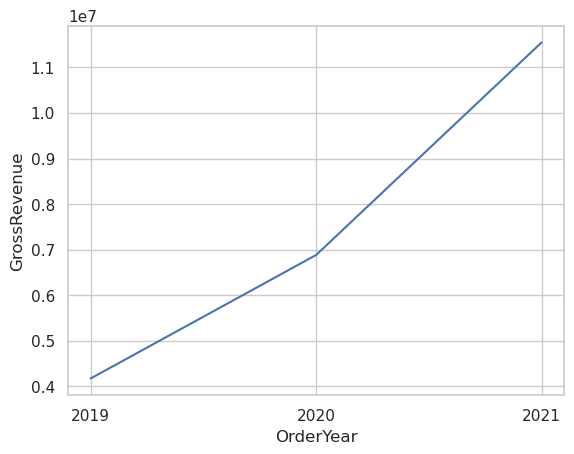

In [59]:
import seaborn as sns

# Clear the plot area
plt.clf()

# Create a line chart
ax = sns.lineplot(x="OrderYear", y="GrossRevenue", data=df_sales)

plt.show()